In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import gym
from SimpleSAC.sampler import TrajSampler
from SimpleSAC.model import SamplerPolicy
import locked_doors.room_world.multiroom

In [2]:
locked_doors_train4 = gym.make('CIFARLockedDoorsEnvTrain4-v2')
locked_doors_train100 = gym.make('CIFARLockedDoorsEnvTrain100-v2')
locked_doors_train1000 = gym.make('CIFARLockedDoorsEnvTrain1000-v2')
locked_doors_test_env = gym.make('CIFARLockedDoorsEnvTest')

Files already downloaded and verified


/media/3tb/chet/miniconda3/envs/SimpleSAC/lib/python3.8/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Files already downloaded and verified
Files already downloaded and verified


/media/3tb/chet/miniconda3/envs/SimpleSAC/lib/python3.8/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `CIFARLockedDoorsEnvTest-v2` instead of the unversioned environment `CIFARLockedDoorsEnvTest`
  logger.warn(


Files already downloaded and verified


In [3]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model(model_path):
    with open(model_path, 'rb') as model_file:
        return pickle.load(model_file)

In [4]:
def descriptor_to_img(descriptor):
    # CIFAR-10 normalization
    image = np.moveaxis(descriptor, 0, 2)
    mu = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    return image * std + mu
    
def sample_trajectories(policy, eval_env, n_trajs, descriptor_id = None, 
        max_traj_length=100, deterministic=False):
    device = get_device()
    sampler_policy = SamplerPolicy(policy, device)
    traj_sampler = TrajSampler(eval_env, max_traj_length)
    return traj_sampler.sample(sampler_policy, n_trajs, 
        deterministic=deterministic, reset_id=descriptor_id)

def plot_trajectories(trajs, traj_infos, eval_env):
    for traj, traj_info in zip(trajs, traj_infos):
        descriptor_img = descriptor_to_img(traj['observations.descriptor'][0])
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(descriptor_img)
        correct_slot = round(traj_info['correct_slot'][0])
        eval_env.sub_envs[correct_slot].room.draw(ax2)
        ax2.plot(*traj['observations.state'].T, '-o')
        plt.show()

In [5]:
model = get_model('/media/3tb/chet/CQL/experiment_output/66bf1c73d2ed4b49a241e75a7ac1392f/model.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


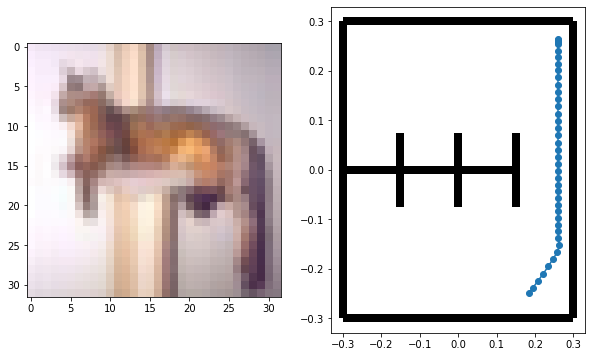

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


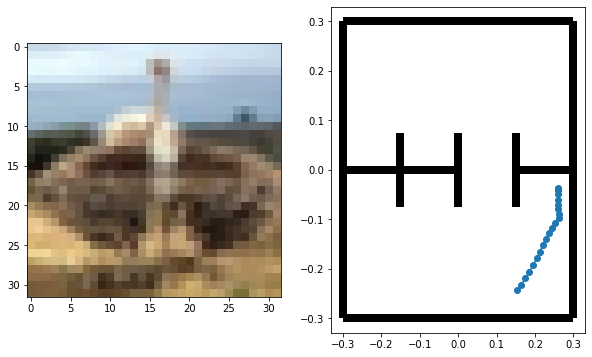

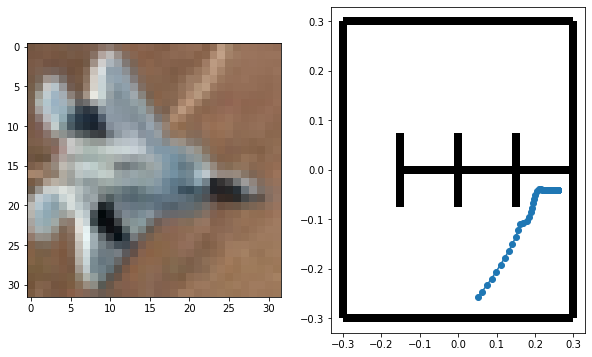

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


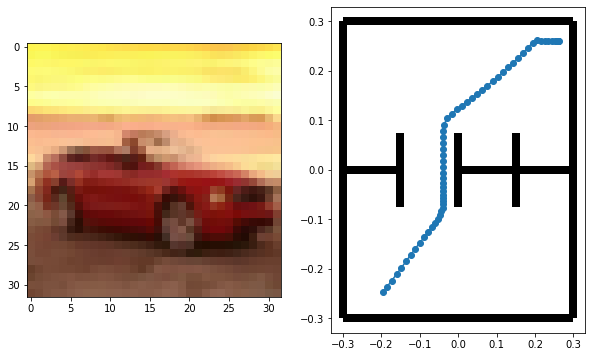

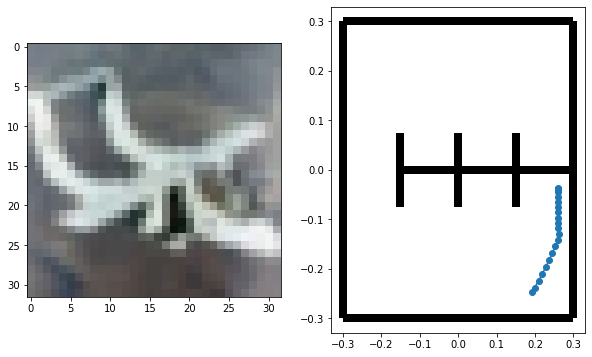

In [12]:
policy = model['sac'].policy

trajs, traj_infos = sample_trajectories(policy, locked_doors_test_env, 5,
    deterministic=True)

plot_trajectories(trajs, traj_infos, locked_doors_test_env)

In [7]:
def gen_obs_mesh(eval_env, mesh_size, descriptor):
    descriptors = np.repeat(np.expand_dims(descriptor, 0), mesh_size**2, 0)
    (xlow, ylow), (xhigh, yhigh) = eval_env.room.get_boundary()
    xs = np.linspace(xlow, xhigh, mesh_size + 2)[1:-1]
    ys = np.linspace(ylow, yhigh, mesh_size + 2)[1:-1]
    X, Y = np.meshgrid(xs, ys)
    coords = np.array([X.flatten(), Y.flatten()]).T
    device = get_device()
    return {
        'state': torch.Tensor(coords).to(device),
        'descriptor': torch.Tensor(descriptors).to(device)
    }

def plot_policy(policy, eval_env, mesh_size, descriptor_id):
    env_id, img_idx = descriptor_id
    descriptor = eval_env.dataset[img_idx][0].numpy()
    descriptor_img = descriptor_to_img(descriptor)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.imshow(descriptor_img)
    obs_mesh = gen_obs_mesh(eval_env, mesh_size, descriptor)
    states = obs_mesh['state']
    with torch.no_grad():
        actions, _ = policy(obs_mesh, deterministic=True)
    eval_env.sub_envs[env_id].room.draw(ax2)
    ax2.quiver(*(*states.cpu().T, *actions.cpu().T))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


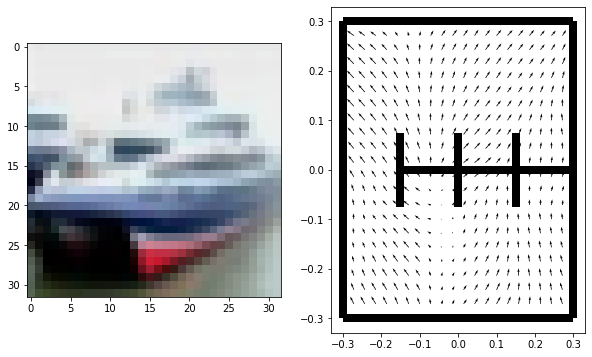

In [8]:
policy = model['sac'].policy
plot_policy(policy, locked_doors_test_env, 20, (0, 1))

In [9]:
def plot_q_vals(q_func, policy, eval_env, mesh_size, descriptor_id):
    env_id, img_idx = descriptor_id
    descriptor = eval_env.dataset[img_idx][0].numpy()
    descriptor_img = descriptor_to_img(descriptor)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.imshow(descriptor_img)
    obs_mesh = gen_obs_mesh(eval_env, mesh_size, descriptor)
    states = obs_mesh['state']
    with torch.no_grad():
        actions, _ = policy(obs_mesh, deterministic=True)
        q_vals = q_func(obs_mesh, actions)
    eval_env.sub_envs[env_id].room.draw(ax2)
    ax2.hist2d(*states.cpu().numpy().T, weights=q_vals.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


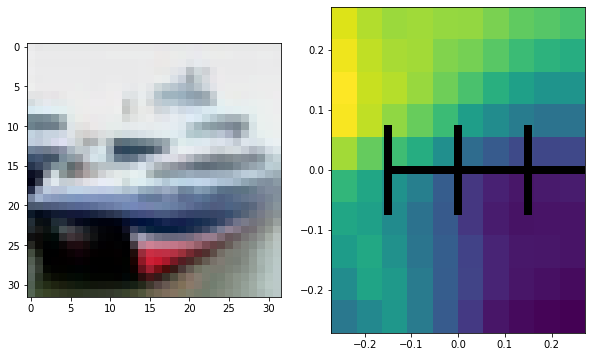

In [10]:
q_func = model['sac'].qf1
policy = model['sac'].policy
plot_q_vals(q_func, policy, locked_doors_test_env, 20, (0, 1))